In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the Excel file
df = pd.read_excel("employee_dataset.xlsx")

In [3]:
# Initial Data Exploration
print("First 5 rows:")
print(df.head())

print("\nData types and info:")
print(df.info())

print("\nDataset dimensions (rows, columns):")
print(df.shape)

First 5 rows:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionL


Missing values per column:
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurre

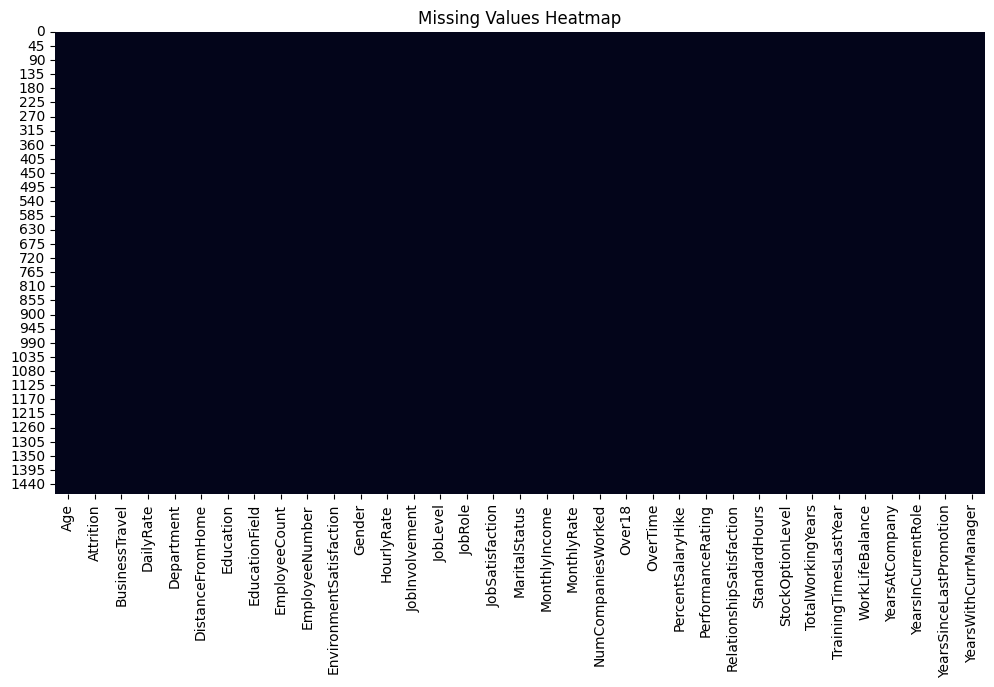

In [4]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Visualize missing data
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

In [5]:
# Data Cleaning
columns_to_drop = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
df = df.drop(columns_to_drop, axis=1)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Attrition'] = le.fit_transform(df['Attrition'])  # Yes=1, No=0
df['OverTime'] = le.fit_transform(df['OverTime'])    # Yes=1, No=0
df['Gender'] = le.fit_transform(df['Gender'])       # Female=0, Male=1

In [6]:
# Update to avoid chained assignment warnings
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].median())  # Fill numerical columns with median
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])  # Fill categorical columns with mode

In [7]:
# One-hot encoding
categorical_cols = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [8]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

numerical_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 
                 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
                 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
                 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
                 'YearsWithCurrManager']

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [9]:
# Feature Engineering
df['TenureGroup'] = pd.cut(
    df['YearsAtCompany'],
    bins=[0, 2, 5, 10, np.inf],
    labels=['New (<2yrs)', 'Mid (2-5yrs)', 'Experienced (5-10yrs)', 'Veteran (>10yrs)']
)

df['SalaryRatio'] = df.groupby('Department_Research & Development')['MonthlyIncome'].transform(
    lambda x: x / x.mean()
)

df['PromotionLag'] = df['YearsAtCompany'] - df['YearsSinceLastPromotion']
df['HighOvertime'] = (df['OverTime'] == 1).astype(int)
df['JobHopper'] = (df['NumCompaniesWorked'] > 3).astype(int)

df = pd.get_dummies(df, columns=['TenureGroup'], drop_first=True)

Top Correlated Features with Attrition:
 Attrition                            1.000000
OverTime                             0.246118
HighOvertime                         0.246118
MaritalStatus_Single                 0.175419
JobRole_Sales Representative         0.157234
BusinessTravel_Travel_Frequently     0.115143
JobRole_Laboratory Technician        0.098290
SalaryRatio                          0.097113
Department_Sales                     0.080855
DistanceFromHome                     0.077924
EducationField_Technical Degree      0.069355
TenureGroup_Experienced (5-10yrs)    0.059511
EducationField_Marketing             0.055781
NumCompaniesWorked                   0.043494
JobRole_Human Resources              0.036215
Gender                               0.029453
JobRole_Sales Executive              0.019774
MonthlyRate                          0.015170
PerformanceRating                    0.002889
JobRole_Research Scientist          -0.000360
HourlyRate                          -0.

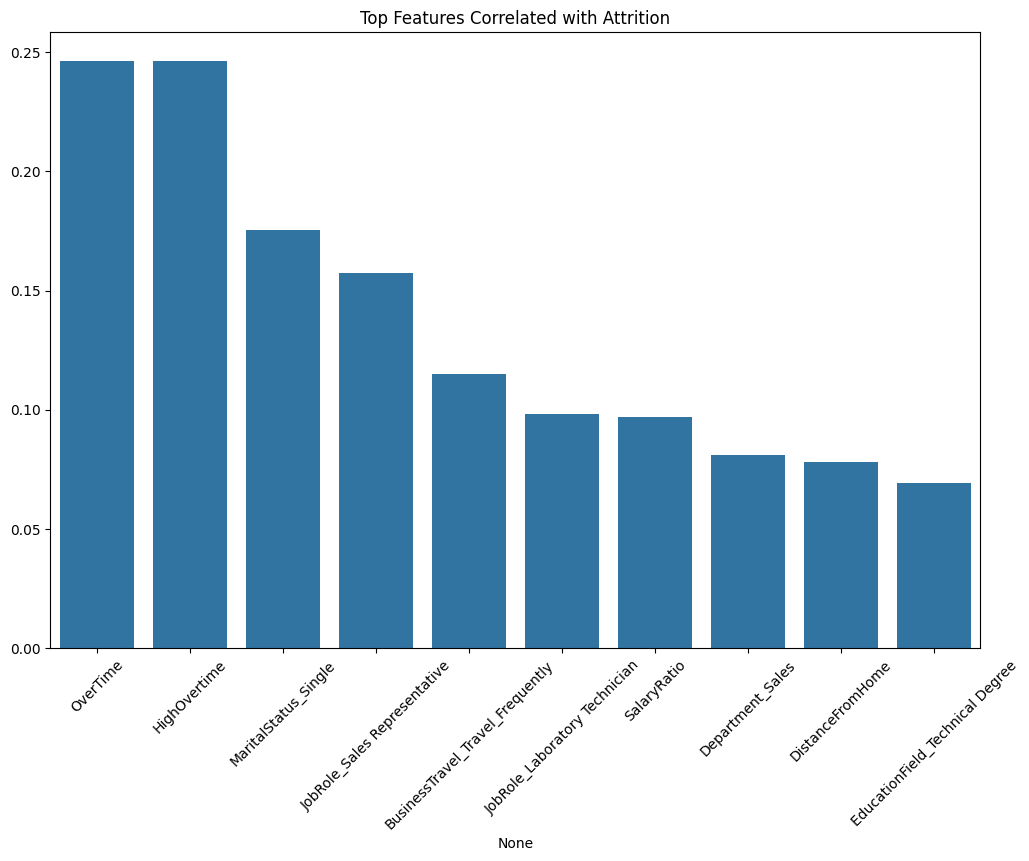

In [10]:
# Correlation with Attrition
corr_matrix = df.corr()
attrition_corr = corr_matrix['Attrition'].sort_values(ascending=False)
print("Top Correlated Features with Attrition:\n", attrition_corr)

plt.figure(figsize=(12, 8))
sns.barplot(x=attrition_corr[1:11].index, y=attrition_corr[1:11].values)
plt.title("Top Features Correlated with Attrition")
plt.xticks(rotation=45)
plt.show()

In [11]:
# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    f1_score, RocCurveDisplay, PrecisionRecallDisplay
)

X = df.drop(['Attrition'], axis=1)
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

In [13]:
# Train baseline models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

for model_name, metrics in results.items():
    print(f"\n{model_name} Performance:")
    print(f"F1-Score: {metrics['f1']:.4f}")
    print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print("Classification Report:")
    print(metrics['classification_report'])


Logistic Regression Performance:
F1-Score: 0.4507
ROC-AUC: 0.8082
Confusion Matrix:
[[239   8]
 [ 31  16]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.92       247
           1       0.67      0.34      0.45        47

    accuracy                           0.87       294
   macro avg       0.78      0.65      0.69       294
weighted avg       0.85      0.87      0.85       294


Decision Tree Performance:
F1-Score: 0.3301
ROC-AUC: 0.6019
Confusion Matrix:
[[208  39]
 [ 30  17]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       247
           1       0.30      0.36      0.33        47

    accuracy                           0.77       294
   macro avg       0.59      0.60      0.59       294
weighted avg       0.78      0.77      0.77       294


Random Forest Performance:
F1-Score: 0.2034
ROC-AUC: 0.7707
Confusion Matrix:
[[241   6]


C:\Users\fazal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fazal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fazal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

In [14]:
# Grid Search for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1-Score (CV): {grid_search.best_score_:.4f}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best F1-Score (CV): 0.3227


In [15]:
# Evaluate best model
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

print("\nOptimized Random Forest Performance:")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))


Optimized Random Forest Performance:
F1-Score: 0.1429
ROC-AUC: 0.7807
Confusion Matrix:
[[242   5]
 [ 43   4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.44      0.09      0.14        47

    accuracy                           0.84       294
   macro avg       0.65      0.53      0.53       294
weighted avg       0.78      0.84      0.79       294



<Figure size 1000x600 with 0 Axes>

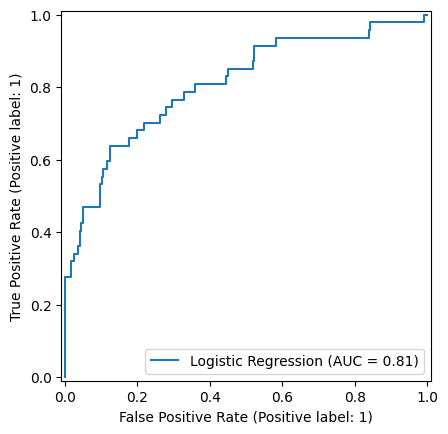

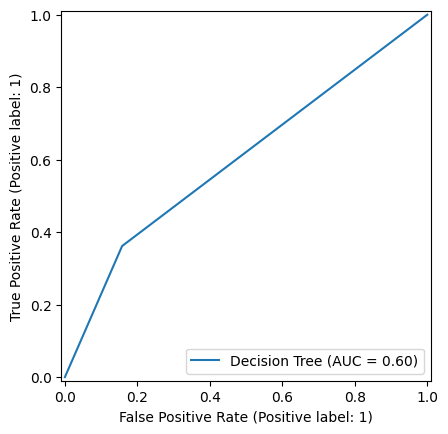

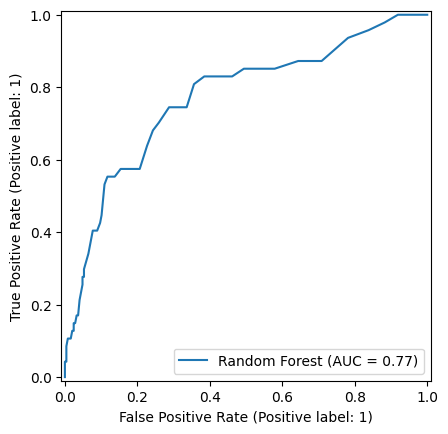

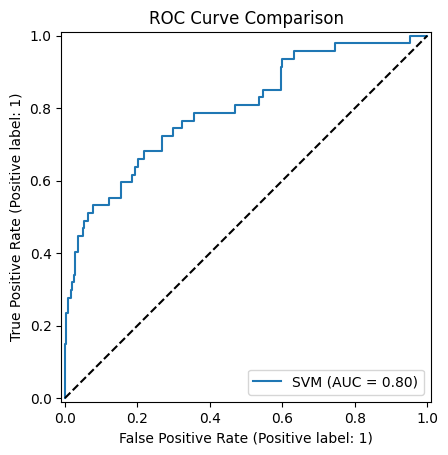

In [16]:
# ROC Curve
plt.figure(figsize=(10, 6))
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.show()

<Figure size 1000x600 with 0 Axes>

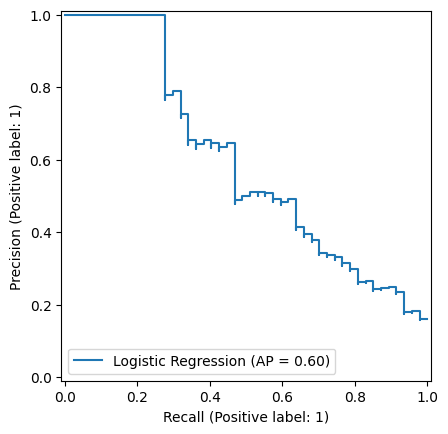

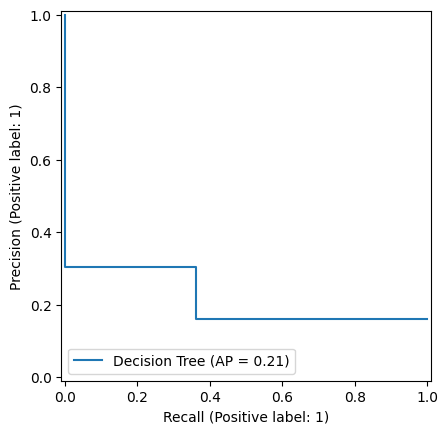

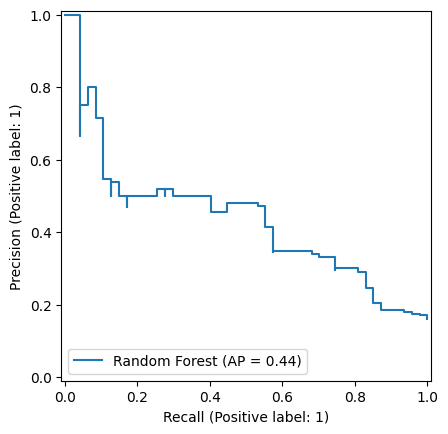

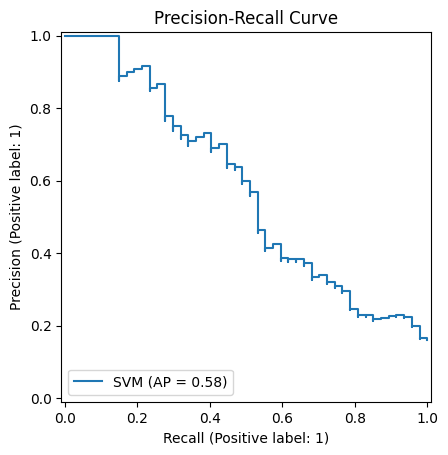

In [17]:
# Precision-Recall Curve
plt.figure(figsize=(10, 6))
for name, model in models.items():
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name=name)
plt.title("Precision-Recall Curve")
plt.show()

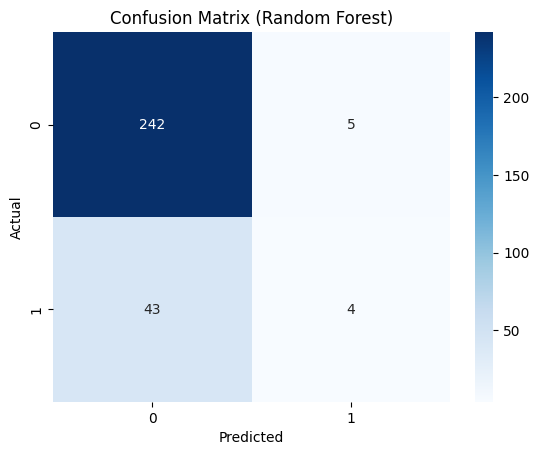

In [18]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

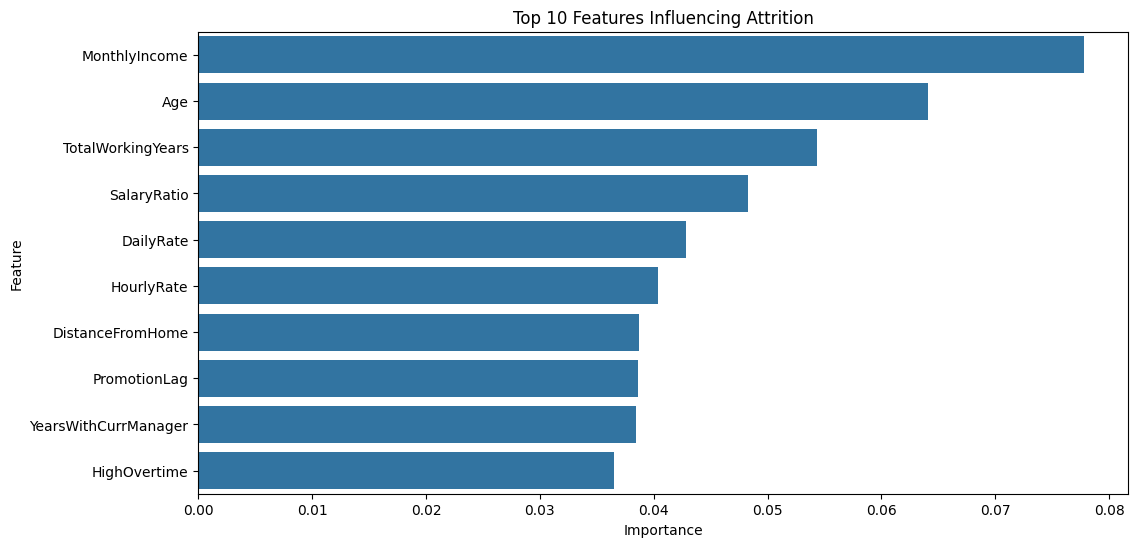

In [19]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Top 10 Features Influencing Attrition")
plt.show()

In [20]:
# -----------------------------------------
# ✅ Predict attrition for all employees
# -----------------------------------------
df['PredictedAttrition'] = best_rf.predict(X)
df['AttritionProbability'] = best_rf.predict_proba(X)[:, 1]

# Save final dataset with predictions
df.to_csv("employee_attrition_predictions.csv", index=False)
print("\n✅ Attrition predictions completed and saved to 'employee_attrition_predictions.csv'")



✅ Attrition predictions completed and saved to 'employee_attrition_predictions.csv'
